In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_score, recall_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
analysis_df = pd.read_pickle('../pkl_files/analysis_df.pkl')
analysis_x = analysis_df.drop(['ponv', 'vomiting24h'], axis=1)
analysis_y = analysis_df['ponv']

In [3]:
# Extract Test Set
tv_x, test_x, tv_y, test_y = train_test_split(analysis_x, analysis_y, test_size=.2, random_state=10)
train_x, val_x, train_y, val_y = train_test_split(tv_x, tv_y, test_size=.25, random_state=444)

In [4]:
import log_reg_tuning as lrt
import Extract_feats_PONV as efp

In [5]:
train_input = efp.total_drug_interaction(analysis_df, tv_x)

/Users/paulchung/Dropbox (Personal)/Paul Working Folder/Home/Coding/Metis/github_backup/Project-3-Classifier/jpnb/Extract_feats_PONV.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_plus_FE['tot_drugs'] = input_plus_FE[['tramadol_dose_pacu', 'ketamine_dose',


In [6]:
final_model = lrt.ponv_log_reg(train_input, tv_y) 

Avg. f1 score: 0.5100269436168303
Avg. Roc/Auc score 0.6763515119632141


In [7]:
final_model.coef_

array([[ 0.25693044,  0.26899168,  0.34609677,  0.06150443,  0.03335027,
        -0.03244043,  0.00457399,  0.11857737, -0.01029932, -0.11143685,
        -0.07399713, -0.04779388,  0.03036829, -0.12737722, -0.02656633,
        -0.09888601, -0.13022477, -0.0905523 , -0.09429716, -0.06797089,
        -0.10214832, -0.26985139,  0.01542435, -0.18692711, -0.00112437,
        -0.08242827, -0.01354896, -0.09436774, -0.02535684,  0.36159877,
        -0.21189793, -0.24616839,  0.038026  , -0.14092645,  0.07597714,
         0.18622592,  0.09113634, -0.0182406 ]])

In [8]:
val_input = efp.total_drug_interaction(analysis_df, val_x)

/Users/paulchung/Dropbox (Personal)/Paul Working Folder/Home/Coding/Metis/github_backup/Project-3-Classifier/jpnb/Extract_feats_PONV.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_plus_FE['tot_drugs'] = input_plus_FE[['tramadol_dose_pacu', 'ketamine_dose',


In [9]:
val_x_sc = lrt.std_scale(train_input, val_input)[1]

In [10]:
final_model.predict(val_x_sc)

array([ True,  True,  True, False,  True, False, False, False, False,
       False, False, False,  True, False,  True,  True, False,  True,
        True,  True, False,  True, False,  True, False,  True, False,
        True,  True, False, False,  True,  True,  True, False,  True,
        True,  True, False,  True, False,  True,  True, False, False,
        True, False,  True, False, False, False, False, False,  True,
       False,  True,  True,  True,  True, False, False, False,  True,
       False,  True, False, False,  True, False, False,  True,  True,
       False,  True, False, False,  True, False,  True, False, False,
       False, False, False,  True,  True, False, False,  True,  True,
       False, False, False,  True, False,  True,  True,  True,  True,
        True,  True, False, False,  True, False,  True,  True, False,
       False,  True,  True,  True,  True,  True, False, False,  True,
        True, False,  True,  True, False, False,  True, False, False,
       False,  True,

In [11]:
confusion_matrix(val_y, final_model.predict(val_x_sc))


array([[151, 115],
       [ 30,  81]])

In [12]:
f1_score(val_y, final_model.predict(val_x_sc))

0.5276872964169381

Logistic Regression Model best F1 score 0.529 at prob decision threshold >= 0.494


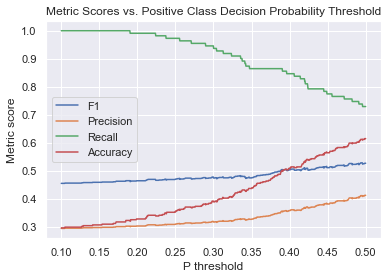

In [13]:
thresh_ps = np.linspace(.10,.50,1000)
model_val_probs = final_model.predict_proba(val_x_sc)[:,1] # positive class probs, same basic logistic model we fit in section 2 

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(val_y, model_val_labels))    
    prec_scores.append(precision_score(val_y, model_val_labels))
    rec_scores.append(recall_score(val_y, model_val_labels))
    acc_scores.append(accuracy_score(val_y, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'])
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

In [14]:
import pickle
pickle.dump(final_model, open('lr_pickled_model.p', 'wb'))

'solver':['liblinear', 'saga'],\
'penalty': ['l1', 'l2'],\
'tol': (1e-6, 100, 'log-uniform'),\
'C': (1e-6, 100, 'log-uniform'),\
'fit_intercept': [True, False]\
LogisticRegression(C=100, penalty='l1', solver='liblinear', tol=1e-06)

# GridSearchCV hypertuning

In [ ]:
param_grid = {
    'solver':['liblinear', 'saga'],
    'penalty': ['l1', 'l2'],
    'tol': (1e-6, 100, 'log-uniform'),
    'C': (1e-6, 100, 'log-uniform'),
    'fit_intercept': [True, False]
}
clf = GridSearchCV(final_model, param_grid=param_grid, cv=10, verbose=True, n_jobs=-1)
best_clf = clf.fit(train_input, tv_y)

In [ ]:
best_clf.best_estimator_

In [ ]:
dict(zip(train_input.columns,final_model.coef_[0]))

# Predict on Test

In [15]:
test_input = efp.total_drug_interaction(analysis_df, test_x)

/Users/paulchung/Dropbox (Personal)/Paul Working Folder/Home/Coding/Metis/github_backup/Project-3-Classifier/jpnb/Extract_feats_PONV.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_plus_FE['tot_drugs'] = input_plus_FE[['tramadol_dose_pacu', 'ketamine_dose',


In [16]:
test_input_sc = lrt.std_scale(train_input, test_input)[1]

In [17]:
final_soft = final_model.predict_proba(test_input_sc)
final_hard = final_model.predict(test_input_sc)
final_cm = confusion_matrix(test_y, final_hard)

In [18]:
f1_score(test_y, final_hard)

0.45390070921985815

In [19]:
final_cm

array([[159, 106],
       [ 48,  64]])

# Apfel Output

In [20]:
import baseline_apfel as apfel

In [23]:
apfel_output = apfel.apfel_prob(test_x, test_y)

/Users/paulchung/Dropbox (Personal)/Paul Working Folder/Home/Coding/Metis/github_backup/Project-3-Classifier/jpnb/baseline_apfel.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apfel_output['apfel_prob'] = apfel_output['apfel'].map({0: .1, 1: .2, 2: .4, 3: .6, 4: .8})
/Users/paulchung/Dropbox (Personal)/Paul Working Folder/Home/Coding/Metis/github_backup/Project-3-Classifier/jpnb/baseline_apfel.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apfel_output['apfel_pred'] = apfel_output['apfel_prob'].ap

In [24]:
confusion_matrix(apfel_output['actual'], apfel_output['apfel_pred'])

array([[172,  93],
       [ 49,  63]])

In [26]:
f1_score(apfel_output['actual'], apfel_output['apfel_pred'])

0.47014925373134325